Find velocity patterns in the weekend by employing data sets taken in from March to July, 2024.

In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.interpolate import splrep, BSpline
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
import seaborn as sns
import glob

In [28]:
# read multiple csv files at once
path = r'data/weekend/'
file = glob.glob(path + "*.csv")

df = []
for f in file:
    df.append(pd.read_csv(f, encoding='cp949'))

# Concatenate all data into one DataFrame
vel = pd.concat(df, ignore_index=True)
vel.head()

,집계일자,집계시분,VDS_ID,지점이정,차로유형구분코드,평균속도,Unnamed: 6
0,2024-03-02,00:00,0010VDE00100,1.4,1,81.08,NaN
1,2024-03-02,00:00,0010VDE00200,2.4,1,94.88,NaN
2,2024-03-02,00:00,0010VDE00300,3.3,1,89.55,NaN
3,2024-03-02,00:00,0010VDE00400,4.5,1,-1.00,NaN
4,2024-03-02,00:00,0010VDE00500,5.1,1,-1.00,NaN


In [29]:
len(vel['집계일자'].unique())

41

In [30]:
vel['hour'] = vel['집계시분'].apply(lambda x: round(int(x.split(":")[0])+int(x.split(":")[1])/60,1))
vel.head()

,집계일자,집계시분,VDS_ID,지점이정,차로유형구분코드,평균속도,Unnamed: 6,hour
0,2024-03-02,00:00,0010VDE00100,1.4,1,81.08,NaN,0.0
1,2024-03-02,00:00,0010VDE00200,2.4,1,94.88,NaN,0.0
2,2024-03-02,00:00,0010VDE00300,3.3,1,89.55,NaN,0.0
3,2024-03-02,00:00,0010VDE00400,4.5,1,-1.00,NaN,0.0
4,2024-03-02,00:00,0010VDE00500,5.1,1,-1.00,NaN,0.0


In [31]:
vel = vel.iloc[:,[2,0,7,5]]
vel = vel.rename(columns={'집계일자':'date','평균속도':'avgVel'})
vel = vel.sort_values(by=['VDS_ID','date','hour'], ignore_index=True)
vel.head()

,VDS_ID,date,hour,avgVel
0,0010VDE00100,2024-03-02,0.0,81.08
1,0010VDE00100,2024-03-02,0.1,90.95
2,0010VDE00100,2024-03-02,0.2,81.32
3,0010VDE00100,2024-03-02,0.2,85.37
4,0010VDE00100,2024-03-02,0.3,79.67


In [32]:
# drop data whose velocity is equal to -1.0, 0.0 or larger than 110
# slice the data
data = []
vds = vel['VDS_ID'].unique()
for i in range(len(vds)*len(vel['date'].unique())):
    data.append(vel['avgVel'].values[288*i:288*(i+1)])
data = np.array(data)
bMask = [np.any((elem!=-1.0)&(elem!=-0.0)) for elem in data]
data = data[bMask]
print(len(data))

249373


In [33]:
# turning back to our data, apply this method to each element of data
data_sp = []
h = np.linspace(0,24,288)
for i in range(len(data)):
    tck = splrep(h, data[i], s=10000)
    data_sp.append(BSpline(*tck)(h))
    
scaler = MinMaxScaler()
data_sp = np.array(data)
scaled_data = scaler.fit_transform(data_sp.reshape(-1,1))
scaled_data = scaled_data.reshape(len(data),288)

C:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\interpolate\_fitpack_py.py:295: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable cause: s too small. (abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)
C:\Users\syj43\AppData\Local\Programs\Python\Python310\lib\site-packages\scipy\interpolate\_fitpack_py.py:295: RuntimeWarning: The maximal number of iterations (20) allowed for finding smoothing
spline with fp=s has been reached. Probable cause: s too small.
(abs(fp-s)/s>0.001)
  res = _impl.splrep(x, y, w, xb, xe, k, task, s, t, full_output, per, quiet)


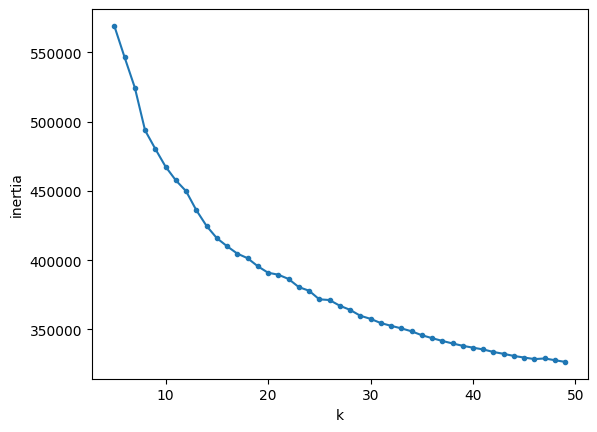

In [34]:
# find the best k for K-Means alg
inertia = []
for k in range(5,50):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

# find an elbow by plotting values of inertia
plt.plot(range(5,50),inertia,'.-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

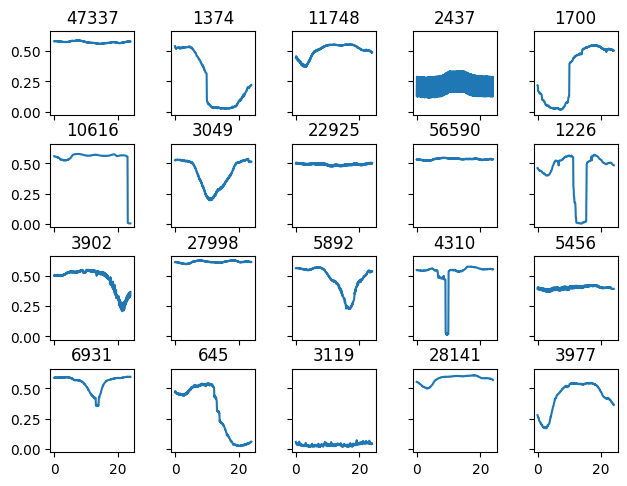

In [35]:
# k=20
km20 = KMeans(n_clusters=20, random_state=42)
km20.fit(scaled_data)
cluster_num20 = list(len(scaled_data[km20.labels_==i]) for i in range(20))

# take the number of elements of clusters as titles
arr = km20.cluster_centers_
row = int(np.ceil(len(arr)/5))
col = 5
fig, axs = plt.subplots(row,col,sharex=True, sharey=True)
plt.tight_layout()
for i in range(row):
    for j in range(col):
        if i*col + j < len(arr):
            axs[i][j].plot(h, arr[col*i+j])
            axs[i][j].set_title(cluster_num20[col*i+j])

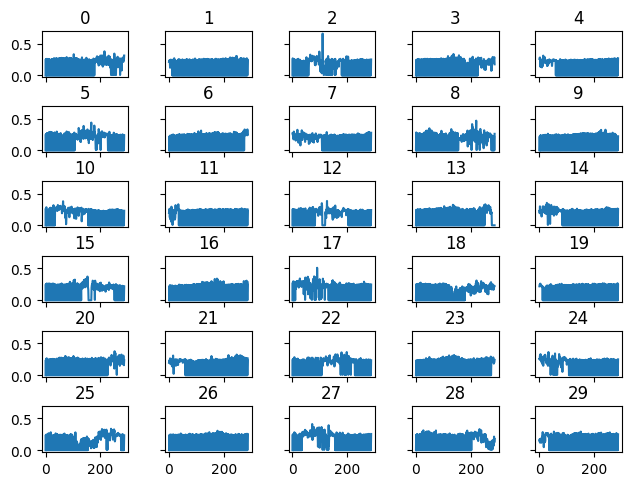

In [20]:
def draw_pattern(arr):
    row = int(np.ceil(len(arr)/5))
    col = 5
    fig, axs = plt.subplots(row,col,sharex=True, sharey=True)
    plt.tight_layout()
    for i in range(row):
        for j in range(col):
            if i*col + j < len(arr):
                axs[i][j].plot(range(len(arr[col*i+j])), arr[col*i+j])
                axs[i][j].set_title(col*i+j)

draw_pattern(scaled_data[km20.labels_==8][:30])

too much noise has not been properly dealt with despite data cleaning.

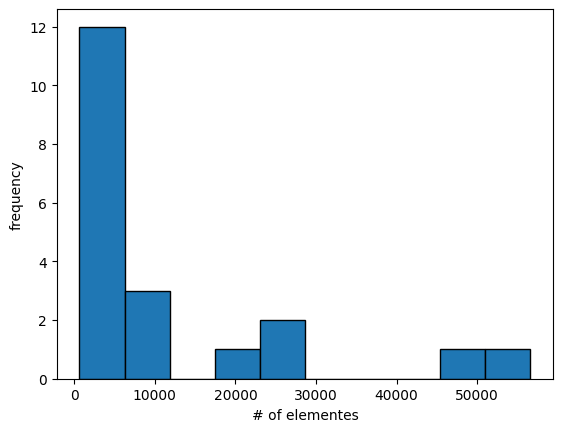

In [36]:
# check a balance between clusters
plt.hist(cluster_num20, edgecolor='k') #,bins=[100*i for i in range(8)]
plt.xlabel('# of elementes')
plt.ylabel('frequency')
plt.show()

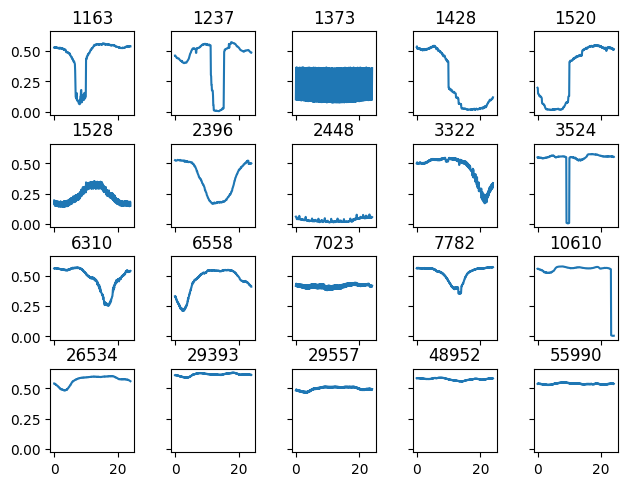

In [26]:
# sort the plots in the descending order by using np.argsort
cluster_num20 = list(len(scaled_data[km20.labels_==i]) for i in range(20))
cluster_num20_sorted = sorted(cluster_num20)
sorted_index = np.argsort(cluster_num20)
sorted_arr = []
for i in sorted_index:
    sorted_arr.append(km20.cluster_centers_[i])
    
row = int(np.ceil(len(sorted_arr)/5))
col = 5
fig, axs = plt.subplots(row,col,sharex=True, sharey=True)
plt.tight_layout()
for i in range(row):
    for j in range(col):
        if i*col + j < len(sorted_arr):
            axs[i][j].plot(h, sorted_arr[col*i+j])
            axs[i][j].set_title(cluster_num20_sorted[col*i+j])